# How to Buy a Van
##### Sean Wade

With upcomming graduation I have been thinking very seriouly about my future.  What will I do for work? How will I handle finding meaningfull relationships with all my cash money?  And most importantly, where will I live? In the midst of all these difficult decisions I keep comming back to one answer.  I need to buy and live in a van. 

There is a lot that goes into making a good van to live in. There is size, space, age, design, and much more.  To find one I have been constantly checking the online classifieds site KSL for any good deals.  I was doing this one night and I thought, "I am better than this".  With a little bit of web scrapping, coding, and machine learning magic I could create a system that would automatically check, update, and analyze new van posts to see if they are a good deal.  All this could be done without me having to do anything so I could have more time to hot tub and eat taquitos.

<div></div>
<img src='nb_images/live-in-van2.jpg' align='left' style='width:325px; height:250px'>
<img src='nb_images/live-in-van3.jpg' align='left' style='width:325px; height:250px'>
<img src='nb_images/live-in-van1.jpg' align='left' style='width:325px; height:250px'>

In [1]:
from bs4 import BeautifulSoup
from urlparse import urljoin
import requests
import re
import string
import tqdm
import pandas as pd
import os
import datetime
import sqlite3
from PIL import Image
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/2kABweT').read())

## Create The Database

Since we will be constantly adding and updating data it only makes sense to use a database.  Writing to a CSV or some other file will be slow and dosn't scale well when I have millions of vans I need to look at.

In [2]:
if False:
    make_table = '''
        CREATE TABLE "vans" (
        "index" INTEGER,
          "body" TEXT,
          "cylinders" TEXT,
          "date_added" TIMESTAMP,
          "dealer_license" TEXT,
          "description" TEXT,
          "drive_type" TEXT,
          "exterior_color" TEXT,
          "exterior_condition" TEXT,
          "fav_num" INTEGER,
          "fuel_type" TEXT,
          "interior_color" TEXT,
          "interior_condition" TEXT,
          "liters" TEXT,
          "make" TEXT,
          "mileage" REAL,
          "model" TEXT,
          "number_of_doors" TEXT,
          "page_views" INTEGER,
          "price" INTEGER,
          "stock_number" TEXT,
          "title_type" TEXT,
          "transmission" TEXT,
          "trim" TEXT,
          "vin" TEXT UNIQUE,
          "year" INTEGER
        );
        '''

    conn = sqlite3.connect("cars.db")
    cur = conn.cursor()
    cur.execute('DROP TABLE IF EXISTS vans;')
    cur.execute(make_table)

## Scrape the Data

I live in Utah, and for some reason nobody uses Craigslist here...  There is a popular alternative classifieds site here named KSL that I will use for my data.  To get my data I will create a web crawler to scrape the new van data and store it in my database.

In [3]:
def getLastDate(cur):
    ''' Gets the last date added to the database. '''
    cur.execute('SELECT date_added FROM vans ORDER BY date(date_added) DESC')
    most_recent = datetime.datetime.strptime(cur.fetchone()[0], '%Y-%m-%d %H:%M:%S')
    return most_recent

In [4]:
def updateData():
    query = string.Template('https://www.ksl.com/auto/search/index?p=&priceFrom=1&priceTo=20000&miles=25&keyword=van&page=$page_num&cx_navSource=hp_search')
    query_page = requests.get(query.substitute(page_num=0))
    soup = BeautifulSoup(query_page.text)
    BASE_URL = 'https://www.ksl.com'

    conn = sqlite3.connect("vans.db")
    cur = conn.cursor()
    
    last_date = getLastDate(cur)

    last_page = int(soup.find(title='Go to last page').text)
    data = []
    for page_num in tqdm.tqdm(range(last_page)):
        query_text = query.substitute(page_num=page_num)
        query_page = requests.get(query_text)
        page = BeautifulSoup(query_page.text)
        listings = page.find_all(class_='listing')
        for add in listings:
            try:
                query_page = requests.get(urljoin(BASE_URL, add.find('a')['href']))
                sub_soup = BeautifulSoup(query_page.text)

                car_data = {}

                listing_specs = sub_soup.find('ul', class_='listing-specifications')
                for row in listing_specs.find_all('li'):
                    label = row.find(class_='title').text.lower().replace(':','').replace(' ','_')
                    s = row.find(class_='value').text.rstrip().lower()
                    value = re.sub(r'\W+', '', s)
                    car_data[label] = value

                price = sub_soup.find('h3', class_='price cXenseParse').text
                price = int(''.join(re.findall('\d+', price)))
                car_data['price'] = price

                loc_str = sub_soup.find('h2', class_='location').text
                loc_str = loc_str.split('Posted ')[1]
                date = datetime.datetime.strptime(loc_str, '%B %d, %Y')
                car_data['date_added'] = date
                
                # check if already have info
                if (date - last_date).days < -1:
                    conn.commit()
                    print "Up to date."
                    return

                vdp = sub_soup.find_all('ul', class_='vdp-contact-list')[1]

                page_views =  vdp.find(class_="vdp-info-key", text='Page Views').parent.find(class_="vdp-info-value")
                page_views =  int(re.findall('\d+', page_views.text)[0])
                car_data['page_views'] = page_views

                fav_num = vdp.find(class_="vdp-info-key", text='Favorite of').parent.find(class_="vdp-info-value")
                fav_num =  int(re.findall('\d+', fav_num.text)[0])
                car_data['fav_num'] = fav_num

                description = sub_soup.find('div', class_='short').text.strip().replace('\n',' ').lower()
                car_data['description'] = description
                data.append(car_data)

                # Add to database
                columns = ', '.join(car_data.keys())
                placeholders = ':'+', :'.join(car_data.keys())
                q = 'INSERT INTO vans ({}) VALUES ({})'.format(columns, placeholders)
                try:
                    cur.execute(q, car_data)
                except sqlite3.IntegrityError as e:
                    conn.commit()
                    print "Already have data"
                    return

                # get the images
                try:
                    path =  './images/{}'.format(car_data['vin'])
                    if not os.path.isdir(path):
                        os.mkdir(path)
                        slider = sub_soup.find('ul', class_='slides').find_all('li')
                        for i, pic in enumerate(slider):
                            image = requests.get(pic.img['src'])
                            with open('./images/{}/{}.jpg'.format(car_data['vin'], i), 'wb') as f:
                                f.write(image.content)
                except:
                    print "Error downloading image, skipping..."
            except:
                print "Already in the database..."
        conn.commit()

    conn.commit()
    conn.close()
    return

## Accessing the Data

Now that I have data on data I can query it and check out these beautiful vans (and sift out the garbage).

In [5]:
def findPictures(vin):
    cwd = os.getcwd()
    image_dir = os.path.join(cwd, 'images', vin)
    for image in os.listdir(image_dir):
        img = mpimg.imread(os.path.join(cwd,'images',vin,image))
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()

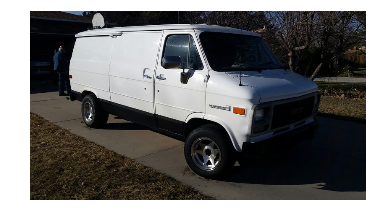

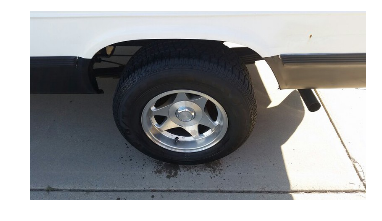

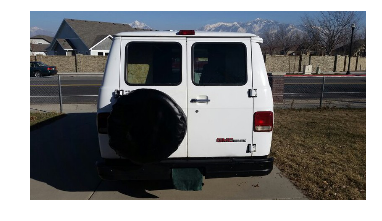

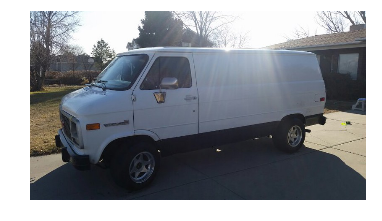

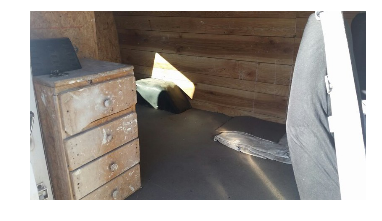

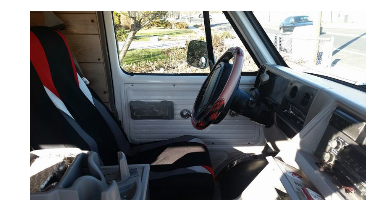

In [6]:
findPictures('1GTDG15H3SF533137')

Now that is a van I could live in!

Next I want to find all the vans that cost less than 5000 and has more than 40 favorites.

In [7]:
conn = sqlite3.connect("cars.db")
cur = conn.cursor()

In [8]:
df = pd.read_sql_query('SELECT * FROM vans;', conn)

In [9]:
results = pd.read_sql_query('SELECT vin, price, fav_num, description from vans where price<5000 and fav_num > 40;', conn)

In [10]:
results['vin']

0    1a4gp45r56b615921
1        f44cd8v715555
2    jhmes26773s001704
3    1falp52u7tg313098
4    1jcux7814ft015299
5    1fdke30gsrha07013
Name: vin, dtype: object

## Enter Machine Learning

Now with all this raw data the challange is to teach the computer what it means to be a prime van.  Since I don't got the time or funds to sift through all this data manually and label it I will have to use another huristic.  As I have looked for a van manually I have noticed that the best vans tend to have lots of views and favorites.  The unfortunate part is often once I find these vans they have allready been takin... My idea is to train my model on previous wonder vans with this as a mesure of quality.  Once trained I could then hopefully detect these gems before some hippie snags them up.

In [79]:
# read database into dataFrame
data = pd.read_sql_query('SELECT * FROM vans;', conn)

In [80]:
data.head()

,index,body,cylinders,date_added,dealer_license,description,drive_type,exterior_color,exterior_condition,fav_num,...,model,number_of_doors,page_views,price,stock_number,title_type,transmission,trim,vin,year
0,None,van,6,2017-02-14 00:00:00,None,801-787-1668. 2009 dodge grand caravan sxt pri...,notspecified,brightsilvermetallic,notspecified,1,...,grandcaravan,notspecified,383,6999,c5263,salvagetitle,automatic,sxt,2d8hn541x9r658126,2009
1,None,van,6,2017-02-14 00:00:00,None,500obo. the van is still in pretty good condit...,2wheeldrive,other,good,0,...,astrovan,3,12,500,None,cleantitle,automatic,lt,1gndm19w9tb192778,1996
2,None,van,6,2017-02-14 00:00:00,None,clean title...very nice....2004 chevrolet vent...,fwd,gold,notspecified,8,...,venture,notspecified,163,1999,None,notspecified,automatic,notspecified,1gndx03e04d249442,2004
3,None,van,6,2017-02-14 00:00:00,None,clean title...very nice....zero accident....20...,fwd,green,notspecified,4,...,sienna,notspecified,142,1499,None,notspecified,automatic,le,4t3zf13cx1u402901,2001
4,None,minivan,6,2017-02-14 00:00:00,None,"2013 dodge grand caravan sxt, ** accident free...",notspecified,white,notspecified,1,...,grandcaravan,4,67,11375,1635982,notspecified,automatic,sxt,2c4rdgcg9dr811482,2013


## Cleaning the Data

In [81]:
# Drop not so great columns
data.drop(['index', 'cylinders', 'dealer_license', 'exterior_color', 'interior_color', 'fuel_type', 'liters', 'number_of_doors', 'stock_number','trim'], axis=1, inplace=True)

In [82]:
# CLean messy labels
data.drive_type.replace(['fwd', 'awd', '4wheeldrive'], ['4wd']*3, inplace=True)
data.drive_type.replace(['2wheeldrive', 'rwd'], ['2wd']*2, inplace=True)

### One-Hot Encode All Categorical Data

In [83]:
def one_hotify(data, key):
    # One-hot encode key attribute
    data = pd.concat([data, pd.get_dummies(data[key])], axis=1)
    data.drop(key, 1, inplace=True)
    return data

categorical_data = [
    'body',
    'interior_condition',
    'exterior_condition',
    'title_type',
    'transmission',
    'drive_type',
    'make',
    'model']

for column in categorical_data:
    data = one_hotify(data, column)
    try:
        data.drop('notspecified', axis=1, inplace=True)
    except:
        print 'Unspecified not in %s' % column  

In [84]:
data.drop(['vin', 'description', 'date_added'], axis=1, inplace=True)

In [85]:
# Drop nan values
data['mileage'] = data['mileage'].replace('notspecified', np.nan)
data['year'] = data['year'].replace('notspecified', np.nan)
data.dropna(axis=0, inplace=True)

### Create Training Labels

In [86]:
labels = data['fav_num'] > 10

In [87]:
data.drop(['fav_num','page_views'], axis=1, inplace=True)

## Make the Models

In [88]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [89]:
x_train, x_test, y_train, y_test = train_test_split(data.as_matrix(), labels.as_matrix())

In [90]:
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.88516746411483249

In [91]:
confusion_matrix(y_test, model.predict(x_test))

array([[185,   0],
       [ 24,   0]])

In [92]:
model = GradientBoostingClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8564593301435407

In [93]:
confusion_matrix(y_test, model.predict(x_test))

array([[176,   9],
       [ 21,   3]])

In [94]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.85167464114832536

In [95]:
confusion_matrix(y_test, model.predict(x_test))

array([[173,  12],
       [ 19,   5]])

In [96]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.79904306220095689

In [97]:
confusion_matrix(y_test, model.predict(x_test))

array([[160,  25],
       [ 17,   7]])

In [98]:
model = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=15)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8564593301435407

In [99]:
confusion_matrix(y_test, model.predict(x_test))

array([[175,  10],
       [ 20,   4]])

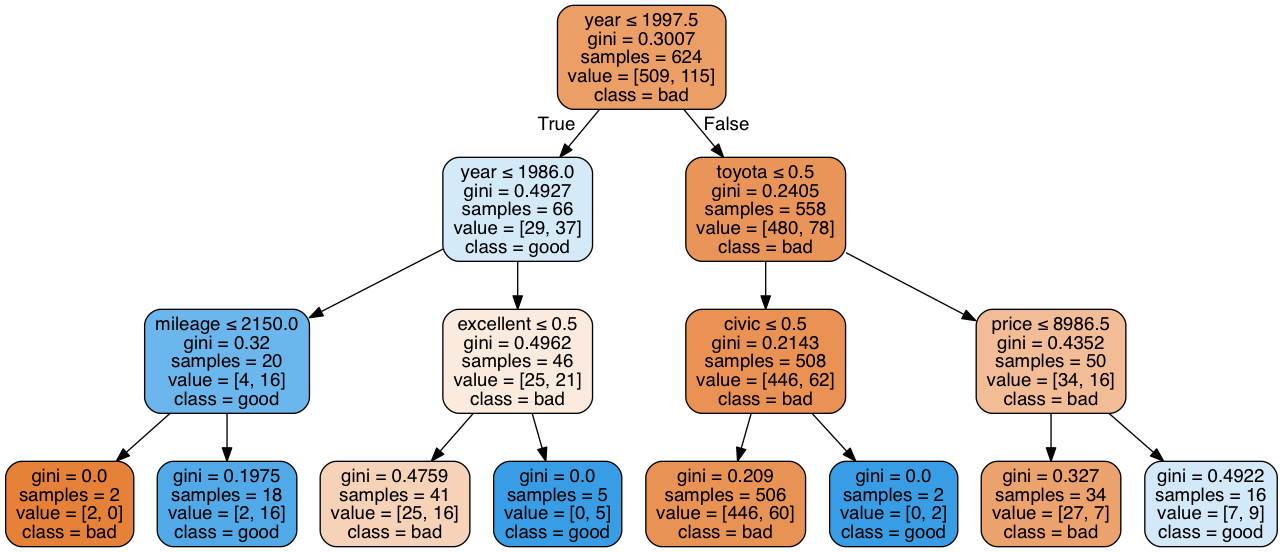

In [100]:
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(model, out_file=None,
                        feature_names=[x.encode('utf-8') for x in data.columns],      
                         class_names=['bad','good'],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf("tree.pdf") 
Image(graph.create_png())  

<h1 align='center'>WOW!</h1>